# Project 1 Part B
## Lilit Petrosyan

First we import the relevant libraries for this project.

In [10]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

In the following cell, we will load the cleaned data from Part A of Project 1. Note that we will be using the relevant data files based on the staff solution.

In [11]:
ins = pickle.load(open('./data/ins.p', 'rb'))
vio = pickle.load(open('./data/vio.p', 'rb'))
ins2vio = pickle.load(open('./data/ins2vio.p', 'rb'))
bus = pickle.load(open('./data/bus.p', 'rb'))

**Note**: For all parts of this project requiring you to produce a visualization, we won't be enforcing any specific size on the plots you make, as long as they are clear (i.e. no overlaps) and follow the specifications. 

<br/><br/><br/><br/>

---

<br/><br/>

## 1: Explore Inspection Scores

In this first part we explore some of the basic inspection score values visually.

<br/><br/><br/>

---


### Question 1a
Let's look at the distribution of inspection scores. As we saw before when we called head on this data frame, inspection scores appear to be integer values. The discreteness of this variable means that we can use a barplot to visualize the distribution of the inspection score. Make a bar plot of the counts of the number of inspections receiving each score.

It should look like the image below. It does not need to look exactly the same (e.g., no grid), but make sure that all labels and axes are correct.

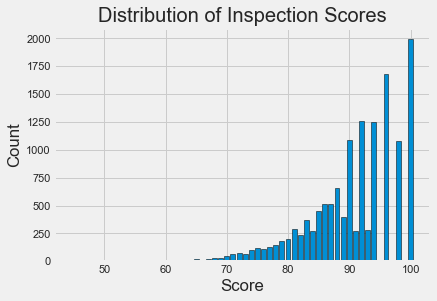

In [12]:
ins = ins[ins['score'] > 0]
score_counts = ins['score'].value_counts()
plt.bar(score_counts.keys(), score_counts, edgecolor='black')
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Distribution of Inspection Scores");

<br/><br/><br/>

---

### Question 1b
Let's figure out which restaurants had the worst scores ever (single lowest score). Let's start by creating a new dataframe called `ins_named`. It should be exactly the same as ins, except that it should have the name and address of every business, as determined by the bus dataframe. If a `business_id` in ins does not exist in bus, the name and address should be given as `NaN`.

In [13]:
ins_named = ins.merge(bus[["bid", "name", "address"]], left_on = "bid", right_on = "bid")
ins_named.head()

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
0,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,False,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B
1,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,False,AMICI'S EAST COAST PIZZERIA,475 06th St
2,100041_20190520,05/20/2019 12:00:00 AM,83,Routine - Unscheduled,100041,2019-05-20,2019,False,UNCLE LEE CAFE,3608 BALBOA ST
3,100055_20190425,04/25/2019 12:00:00 AM,98,Routine - Unscheduled,100055,2019-04-25,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
4,100055_20190912,09/12/2019 12:00:00 AM,82,Routine - Unscheduled,100055,2019-09-12,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr


In [19]:
worst_restaurant = ins_named.sort_values('score', ascending=False).tail(1)['name'].iloc[0]
worst_restaurant

'Lollipot'

**Use the cell above to identify the restaurant** with the lowest inspection scores ever. Be sure to include the name of the restaurant as part of your answer in the cell below. You can also head to yelp.com and look up the reviews page for this restaurant. Feel free to add anything interesting you want to share.

**SOLUTION:**

The restaurant with the worst score is Lollipot.

Just for fun you can also look up the restaurants with the best scores.

<br/><br/><br/><br/>

---

<br/><br/>

## 2: Restaurant Ratings Over Time

Let's consider various scenarios involving restaurants with multiple ratings over time.


<br/><br/><br/>

---

### Question 2a

Let's see which restaurant has had the most extreme improvement in its rating, aka scores. Let the "swing" of a restaurant be defined as the difference between its highest-ever and lowest-ever rating. **Only consider restaurants with at least 3 ratings, aka rated for at least 3 times (3 scores)!** Using whatever technique you want to use, assign `max_swing` to the name of restaurant that has the maximum swing.

*Note*: The "swing" is of a specific business. There might be some restaurants with multiple locations; each location has its own "swing".

In [20]:
def swing(s):
    if len(s) < 3:
        return 0
    return max(s) - min(s)

swing_series = ins_named['score'].groupby(ins_named['bid']).agg(swing).rename('swing')
bus_swing = pd.concat([bus.set_index('bid'), swing_series], axis=1).sort_values("swing", ascending=False)
bus_swing
max_swing = bus_swing.iloc[0]['name']
max_swing

'Lollipot'

<br/><br/><br/>

---

### Question 2b

To get a sense of the number of times each restaurant has been inspected, create a multi-indexed dataframe called `inspections_by_id_and_year` where each row corresponds to data about a given business in a single year, and there is a single data column named count that represents the number of inspections for that business in that year. The first index in the MultiIndex should be on `bid`, and the second should be on year.

In [22]:
inspections_by_id_and_year = ins.groupby([ins['bid'], ins['year']]).size().rename("count").to_frame() 
inspections_by_id_and_year.head()

count
bid year       
19  2017      1
    2018      1
24  2016      1
    2017      1
    2019      1

You should see that some businesses are inspected many times in a single year. Let's get a sense of the distribution of the counts of the number of inspections by calling `value_counts`. There are quite a lot of businesses with 2 inspections in the same year, so it seems like it might be interesting to see what we can learn from such businesses.

In [23]:
inspections_by_id_and_year['count'].value_counts()

1    10580
2     1688
3       25
Name: count, dtype: int64

<br/><br/><br/>

---


### Question 2c

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? For simplicity, let's focus on only 2018 for this problem, using `ins2018` data frame that will be created for you below.

First, make a dataframe called `scores_pairs_by_business` indexed by `business_id` (containing only businesses with exactly 2 inspections in 2018). This dataframe contains the field score_pair consisting of the score pairs ordered chronologically [first_score, second_score].

Plot these scores. That is, make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1.

You may find the functions `sort_values`, `groupby`, `filter` and `agg` helpful, though not all necessary.

The first few rows of the resulting table should look something like:

|     | **score_pair** |
|-----|------------|
| **bid** |            |
| 48  | [94, 87]   |
| 66  | [98, 98]   |
| 146  | [81, 90]   |
| 184  | [90, 96]  |
| 273  | [83, 84]   |

In the cell below, create `scores_pairs_by_business` as described above.

In [24]:
ins2018 = ins[ins['year'] == 2018]
scores_pairs_by_business = (ins2018.sort_values('date')
                            .loc[:, ['bid', 'score']]
                            .groupby('bid')
                            .filter(lambda group: len(group)==2)
                            .groupby('bid')
                            .agg(list)
                            .rename(columns={'score':'score_pair'}))
scores_pairs_by_business

,score_pair
bid,
48,"[94, 87]"
66,"[98, 98]"
146,"[81, 90]"
184,"[90, 96]"
273,"[83, 84]"
...,...
95621,"[100, 100]"
95628,"[75, 75]"
95674,"[100, 96]"


Now, create your scatter plot in the cell below. It does not need to look exactly the same (e.g., no grid) as the sample below, but make sure that all labels, axes and data itself are correct.

![](data/2c.png)

Key pieces of syntax you'll need:

`plt.scatter` plots a set of points. Use `facecolors='none'` and `edgecolors=b` to make circle markers with blue borders. 

`plt.plot` for the reference line.

`plt.xlabel`, `plt.ylabel`, `plt.axis`, and `plt.title`.

Note: If you want to use another plotting library for your plots (e.g. `plotly`, `sns`) you are welcome to use that library instead so long as it works on DataHub.

Hint: You may find it convenient to use the `zip()` function to unzip scores in the list.

```
BEGIN QUESTION
name: q2cii
points: 2
manual: True
```

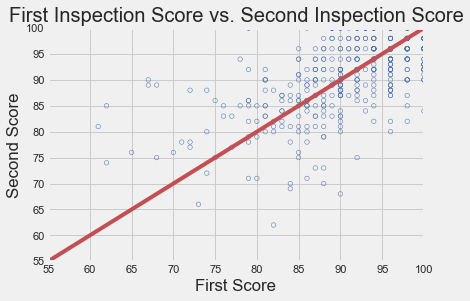

In [25]:
first_score, second_score = zip(*scores_pairs_by_business['score_pair'])
plt.scatter(first_score,second_score,s = 20, facecolors='none',edgecolors='b')
plt.plot([55,100],[55,100],'r-')
plt.xlabel('First Score')
plt.ylabel('Second Score')
plt.axis([55,100,55,100])
plt.title("First Inspection Score vs. Second Inspection Score");

<br/><br/><br/>


---


### Question 2d

Another way to compare the scores from the two inspections is to examine the difference in scores. Subtract the first score from the second in `scores_pairs_by_business`. Make a histogram of these differences in the scores. We might expect these differences to be positive, indicating an improvement from the first to the second inspection.


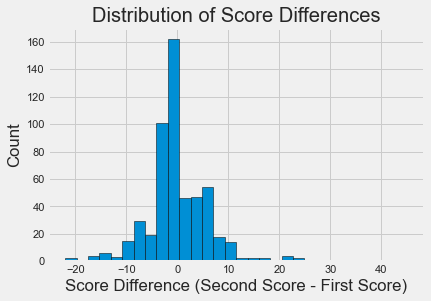

In [26]:
diffs = np.array(second_score) - np.array(first_score)
plt.hist(diffs, bins=30, edgecolor='black')
plt.title("Distribution of Score Differences")
plt.xlabel("Score Difference (Second Score - First Score)")
plt.ylabel("Count");

<br/><br/><br/>

---

### Question 2e
To wrap up our analysis of the restaurant ratings over time, one final metric we will be looking at is the distribution of restaurant scores over time. Create a side-by-side boxplot that shows the distribution of these scores for each different risk category from 2017 to 2019. Use a figure size of at least 12 by 8.

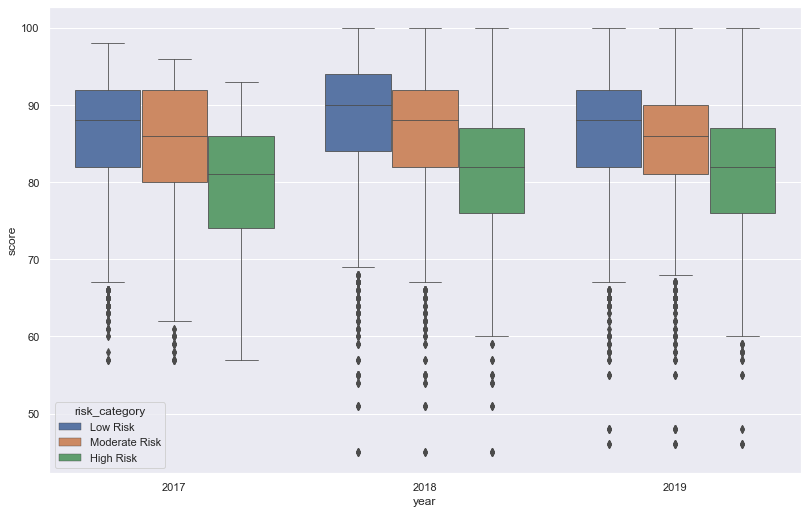

In [27]:
sns.set()
ins_17_to_19 = ins[(ins['year'] >= 2017) & (ins['year'] <= 2019)]
ins_vid_joined = ins_17_to_19.merge(ins2vio, on='iid').merge(vio, on='vid')
plt.figure(figsize=(12,8))
ins_vid_joined['risk_cat'] = 0
ins_vid_joined.loc[ins_vid_joined['risk_category'] == "Moderate Risk" , 'risk_cat'] = 1
ins_vid_joined.loc[ins_vid_joined['risk_category'] == "High Risk", 'risk_cat'] = 2
sns.boxplot(x="year", y="score", hue='risk_category', data=ins_vid_joined.sort_values("risk_cat"), 
            linewidth=0.8);

<br/><br/><br/><br/>

---

<br/><br/>


## Question 3 Interpreting Visualizations ##


<br/><br/><br/>

---

### Question 3a ###

Given a set of data points `(x[i], y[i], c[i])`, a hexbin plot is a visualization of what the aggregated quantity of `c[i]` values are for each coordinate `(x[i], y[i])`.

For example, given the following toy dataset:

| **x** | **y**  | **c** |
|-------|--------|-------|
| 1 | 0  | 3 |
| 1 | 0  | 4 |
| 1 | 0  | 5 |
| 2 | 1  | 1 |
| 2 | 1  | 2 |
| 3 | -1 | 3 |

Assume the aggregate function we are using here is `np.size`, for each coordinate (x, y), we will be counting how many c values there are for that coordinate. Specifically,

- For the coordinate (x = 1, y = 0), we will have an aggregated value of 3 for c because there are three entires corresponding to (x = 1, y = 0).
- For the coordinate (x = 2, y = 1), we will have an aggregated value of 2 for c.
- For the coordinate (x = 3, y = -1) we will have an aggregated value of 1 for c.

These aggregated c values will be used to determine the intensity of the color that we assign to each hexigonal bin. It is also important to see that when the bins have the same size, counting the number of occurrences of c is equivalent to determining the density of c for each coordinate.

In the context of restaurant ratings, we can choose our `x[i]`, `y[i]`, `c[i]` values to be the longitude, latitude, and inspection score for each restaurant in San Francisco respectively. Since `x[i]` and `y[i]` also encode the geolocation of each restaurant, we can produce a geospatial hexbin plot that maps the density of scores to different locations within the city.

In order to produce the geospatial plot, we need to make sure we have all the data we need to create the plot. First, create a DataFrame `rated_geo` that includes the `longitude`, `latitude`, and `score` for each restaurant.

In [28]:
rated_geo = ins.merge(bus[['bid', 'latitude', 'longitude']], on='bid').merge(ins2vio, on='iid').merge(vio, on='vid')
rated_geo = rated_geo[rated_geo['score'] > 0][['score', 'latitude', 'longitude']]
rated_geo = rated_geo[(rated_geo['latitude'] > 30) & 
                      (rated_geo['latitude'] < 50) & 
                      (rated_geo['longitude'] > -150) & 
                      (rated_geo['longitude'] < -100)]

<br/><br/><br/>

---

### Question 3b

Now that we have our DataFrame ready, we can start creating our geospatial hexbin plot.

Using the `rated_geo` DataFrame from 3a, produce a geospatial hexbin plot that shows the inspection count for all restaurant locations in San Francisco. 

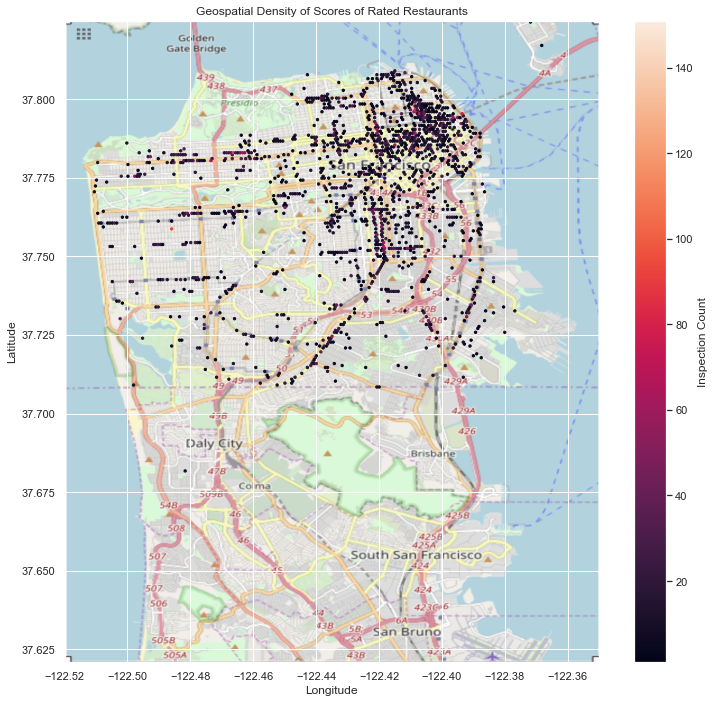

In [29]:
min_lon = rated_geo['longitude'].min()
max_lon = rated_geo['longitude'].max()
min_lat = rated_geo['latitude'].min()
max_lat = rated_geo['latitude'].max()
max_score = rated_geo['score'].max()
min_score = rated_geo['score'].min()
bound = ((min_lon, max_lon, min_lat, max_lat))
min_lon, max_lon, min_lat, max_lat
map_bound = ((-122.5200, -122.3500, 37.6209, 37.8249))
basemap = plt.imread('./data/sf.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])
hb = ax.hexbin(
    rated_geo['longitude'],
    rated_geo['latitude'], 
    rated_geo['score'],
    gridsize=200,
    reduce_C_function=np.size,
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Inspection Count')
plt.title('Geospatial Density of Scores of Rated Restaurants')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');


---

### Question 3c

Now that we've created our geospatial hexbin plot for the density of inspection scores for restaurants in San Francisco, let's also create another hexbin plot that visualizes the **average inspection scores** for restaurants in San Francisco.


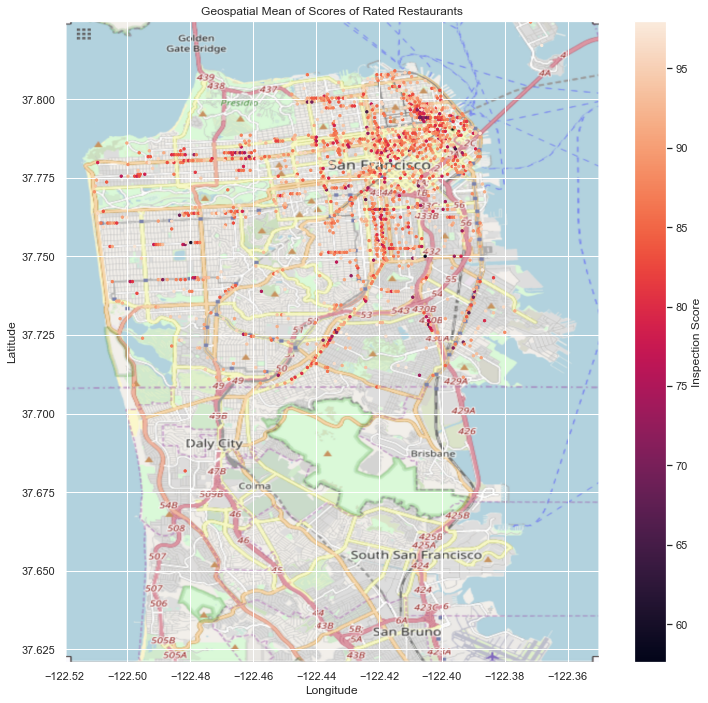

In [30]:
basemap = plt.imread('./data/sf.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])
hb = ax.hexbin(
    rated_geo['longitude'],
    rated_geo['latitude'], 
    rated_geo['score'],
    gridsize=200,
    reduce_C_function=np.mean,
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Inspection Score')
plt.title('Geospatial Mean of Scores of Rated Restaurants')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');

## Summary of Inspections Data
Below are some examples of what we have learned about the inspections data through some cool visualizations!

- We found that the records are at the inspection level and that we have inspections for multiple years.
- We also found that many restaurants have more than one inspection a year.
- By joining the business and inspection data, we identified the name of the restaurant with the worst rating and optionally the names of the restaurants with the best rating.
- We identified the restaurant that had the largest swing in rating over time.
- We also examined the change of scores over time! Many restaurants are not actually doing better.
- We created cool hexbin plots to relate the ratings with the location of restaurants! Now we know where to go if we want good food!